In [1]:
#First try at using a hadronic decay file

In [1]:
import sys 
import os

import numpy as np
import matplotlib.pyplot as plt
import timeit

sys.path.insert(0, '../../MATHUSLA_FastSim/')
import DetectorSimulation.Detector as Detector
import DetectorSimulation.llp_gun_new as lg
from Helpers.functions import *

sys.path.insert(0,'../../FastSim_Additions/')
from Additions import initiate_detector
from run_simulation import do_sim

sys.path.insert(0, '../MixingAnglePlots/')
from MixingAngle_vs_Yield_Plot import get_ctaus

In [2]:
fv_file = '../../SimulationData/ForMixingPlot/RHN_Ue_LLPweight4vectorBmesonlist_mN_0.316228.csv'
fv_path = os.path.join(os.getcwd(), fv_file)
length_file = '../../SimulationData/RHNctauUe.dat'
len_path = os.path.join(os.getcwd(), length_file)
product_file = '../../SimulationData/vN_to_all_0.314228_hadron_style.txt'
prod_path = os.path.join(os.getcwd(), product_file)

In [3]:
mass = float(fv_file.split('_')[-1][:-4])
mixing = 0.004
ctau = get_ctaus(mass = mass, mixing = mixing,length_file = len_path)
detector_benchmark = initiate_detector('../../MATHUSLA_FastSim/param_card_CDR.txt')

In [4]:
detector_benchmark = initiate_detector('../../MATHUSLA_FastSim/param_card_CDR.txt')

In [5]:
start = timeit.default_timer()

vertices = do_sim(fv_path, prod_path, ctau, mass, detector_benchmark, 10000)

end = timeit.default_timer()

print(end - start)

4.394732600019779


In [6]:
import Event_Data_Structure as eds

In [7]:
data = eds.multi_event_data(vertices)

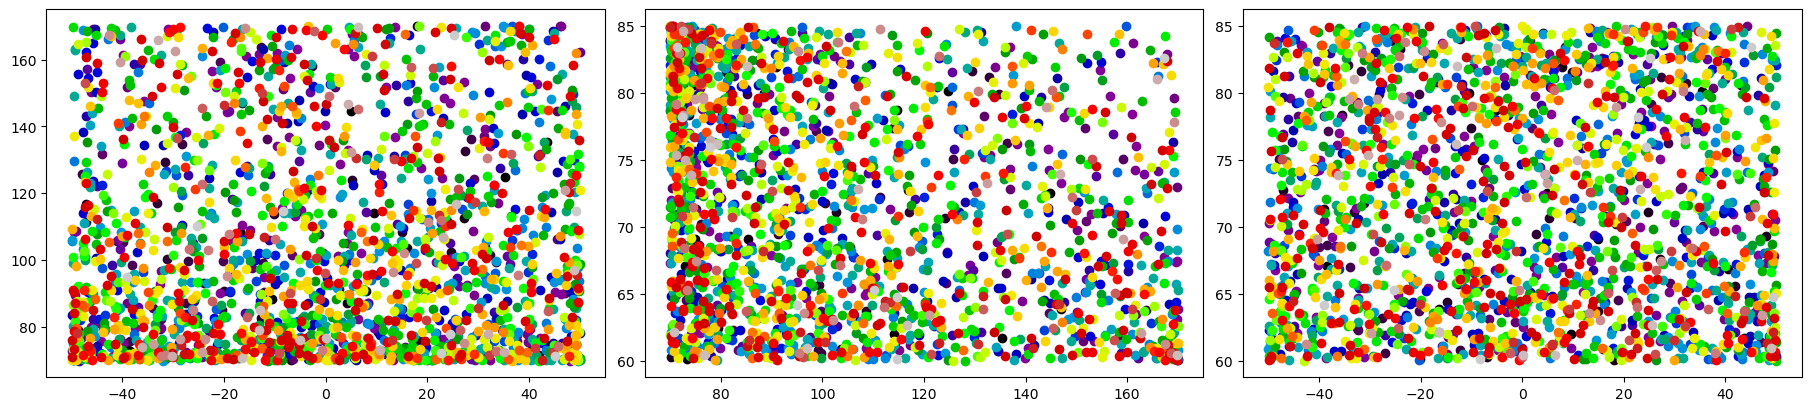

In [16]:
fig, ax = plt.subplots(nrows = 1,ncols = 3, constrained_layout = True, figsize = (6 * 3,4))

colours = plt.cm.nipy_spectral(np.linspace(0,1, len(data[:,0])))

for i, event in enumerate(data[:,0]):
    ax[0].scatter(event[0], event[1], color = colours[i])
    ax[1].scatter(event[1], event[2], color = colours[i])
    ax[2].scatter(event[0], event[2], color = colours[i])


In [17]:
test = vertices[0]

In [19]:
test.particles[0].particle.momentum

array([0.08007139, 0.07606942, 0.10265164, 0.00124068])

In [20]:
better = ak.Array([test.vertex.position,
          test.vertex.momentum,
          np.array([daughter.particle.momentum for daughter in test.particles])])

In [21]:
trying = ak.Array([test.vertex.position, test.vertex.momentum])

In [22]:
def to_dict(llp_vertex):
    return {'position':llp_vertex.vertex.position,
            'momentum':llp_vertex.vertex.momentum,
            'tracks': get_track_information(llp_vertex),
            'recon': llp_vertex.recon_criteria,
            'wall':llp_vertex.wall_hit}

In [23]:
does_dict_work = to_dict(vertices[0])

In [39]:
does_dict_work['tracks']

<Array [[[0.0801, ..., 0.00124], ..., 0], ...] type='3 * var * union[var * ...'>

In [40]:
daughters = does_dict_work['tracks']

In [41]:
daughters

<Array [[[0.0801, ..., 0.00124], ..., 0], ...] type='3 * var * union[var * ...'>

In [42]:
daughters[:,0]

<Array [[0.0801, 0.0761, ..., 0.00124], ...] type='3 * union[var * float64,...'>

In [43]:
tracks = np.array([np.append(daughter.particle.momentum.flatten(), np.array([daughter.particle.pid, len(daughter.tracker_hits)])) for daughter in vertices[0].particles])

In [44]:
tracks

array([[ 8.00713936e-02,  7.60694241e-02,  1.02651639e-01,
         1.24068299e-03,  1.20000000e+01,  0.00000000e+00],
       [-2.58130710e-01,  2.23202387e-01, -1.88760882e-01,
        -3.83115171e-02,  1.20000000e+01,  0.00000000e+00],
       [ 5.15825871e-02,  3.87548977e-02,  5.38848732e-02,
         1.06881613e-02, -1.20000000e+01,  0.00000000e+00]])

In [45]:
builder = ak.ArrayBuilder()
for llp_vertex in vertices:
    tracks = np.array([np.append(daughter.particle.momentum, np.array([daughter.particle.pid, len(daughter.tracker_hits)])) for daughter in llp_vertex.particles])
    builder.append(tracks)

In [46]:
awk_array = builder.snapshot()

In [47]:
awk_array[0].to_numpy()

array([[ 8.00713936e-02,  7.60694241e-02,  1.02651639e-01,
         1.24068299e-03,  1.20000000e+01,  0.00000000e+00],
       [-2.58130710e-01,  2.23202387e-01, -1.88760882e-01,
        -3.83115171e-02,  1.20000000e+01,  0.00000000e+00],
       [ 5.15825871e-02,  3.87548977e-02,  5.38848732e-02,
         1.06881613e-02, -1.20000000e+01,  0.00000000e+00]])

In [25]:
import numba

In [26]:
import timeit

In [48]:
#@numba.jit(nopython = False)
def make_awk(vertices):
    builder = ak.ArrayBuilder()
    for llp_vertex in vertices:
        tracks = np.array([np.append(daughter.particle.momentum, np.array([daughter.particle.pid, len(daughter.tracker_hits)])) for daughter in llp_vertex.particles])
        builder.append(tracks)
        
    return builder.snapshot()

In [49]:
start = timeit.default_timer()

array = make_awk(vertices)

end = timeit.default_timer()

print(end - start)
array

0.06916109996382147


<Array [[[0.0801, 0.0761, ..., 0], ...], ...] type='2029 * var * var * float64'>

In [7]:
data = eds.to_data_structure(vertices)

In [18]:
data['daughters'][:,:,1]

<Array [[0.166, 0.0763, 0.0929], ..., [0.156, ...]] type='2061 * var * float64'>